# Random Forest Weather Data

### Samantha Bothwell
June 11th, 2019

## Random Forest Background

The random forest algorithm is a form of supervised learning. Random Forests are a form of decision trees. In the algorithm, trees are built by choosing a random subset of variables and then the model averages the predicitons of all the trees. 

The random forest algorithm is most often used when there is a mixture of numeric and factor variables. Before using the random forest algorithm, here are some pros and cons to consider:

##### Pros
* You can obtain a reliable variable importance plot that ranks the variables by how helpful they are in predicting the response.
* The algorithm is effectively able to fill in missing information based on what information is present.
* The estimate for the generalization error progresses as the forest builds, and is unbiased.

##### Cons
* This is a black box algorithm - meaning, though it is powerful for predicting, it is difficult to interpret.
* When working with a dataset with significant noise, the algorithm will overfit.
* Variable importance is biased towards categorical variables with more levels. 
* Due to overfitting, the algorithm performs poorly with predicting future data if there is any seasonality.

Random Forest is typically used when your response variable is categorical. This is a classification algorithm and tries to put an observation in the correct category. We can, however, still use the algorithm for a numeric response. The following graphic shows how the Random Forest Algorithm works.

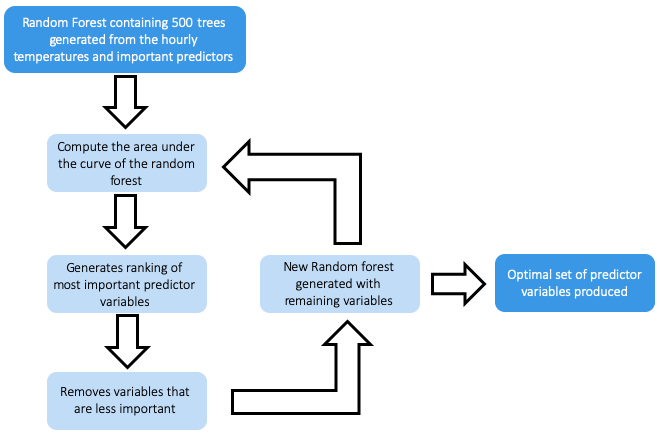

In [124]:
# Load important packages 
import numpy as np
import pandas as pd
import random 
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn import tree
from subprocess import call
from IPython import display
from rfpimp import *
import graphviz
from matplotlib import pyplot as plt
from pdpbox import pdp, info_plots, get_dataset
from sklearn.metrics import mean_squared_error, r2_score


## Data

The data we will be using was taken from http://www.atmos.colostate.edu/fccwx/fccwx_latest.php, a record of climate observations for Fort Collins, CO. The data was taken hourly from June 2018 - June 2019. Later we will look at data from June 2014 - June 2019. We will remove the first column that represents the time the data point was taken. 

In [125]:
# First we will read in the data and clean it
dat = pd.read_csv("Weather.csv")

# Remove first two columns
dat.drop(["Unnamed: 0", "DateTime"], axis = 1, inplace = True)
    
# Rename columns
dat = dat.rename(index=str, columns={"Temp": "Temp_degF", "RH": "Humidity_Pct",
                              "DewPt": "DewPt_degF", "Wind": "Wind_mph",
                              "Dir": "WindDir_degNorth", "Gust": "Gust_mph",
                              "GustDir": "GustDir_degNorth", "Press": "Pressure_Hg",
                              "Solar": "Solar_WatPerSqM", "Prec": "Percip_in"})


## Analysis - Filling in missing data

Now that our data is clean, let's walk through using the Random Forest Algorithm.
First, we will make data sets for testing and training. These are random samples from our original data. We will use the training data to make the model and the testing data to evaluate how effective our model is at making predictions. For this data, I will make my training data 75% of the original data set and testing data the other 25% of the original data set. 

In [126]:
np.random.seed(2019) # set seed for reproducible results

# make training data 75% of the original data
msk = np.random.rand(len(dat)) < 0.75
train = dat[msk]
test = dat[~msk]

X_train, y_train = train.drop('Temp_degF',axis=1), train['Temp_degF']
X_test, y_test = test.drop('Temp_degF',axis=1), test['Temp_degF']


For the model we will try to predict the temperature based on the remaining variables

In [127]:
np.random.seed(2019)
# Random Forest algorithm
rf = RandomForestRegressor(n_estimators = 500) #500 trees in the model

# Train the model on training data
fit = rf.fit(X_train, y_train)


### Visuals

There are many visuals we can make from the Random Forest model to understand our data better. The visuals I will give examples of are:
* Decision Tree
* Variable Importance Plot
* Partial Dependence Plot



#### Decision Tree
We can view one of the trees from the Forest. The following graphic was generated in RStudio using the rpart.plot package. You can use export_graphviz in python to produce a decision tree but the tree is too large to provide any helpful interpretation. This is because our response variable is numeric rather than categorical. This visualization serves to show how the algorithm predicts the temperature.

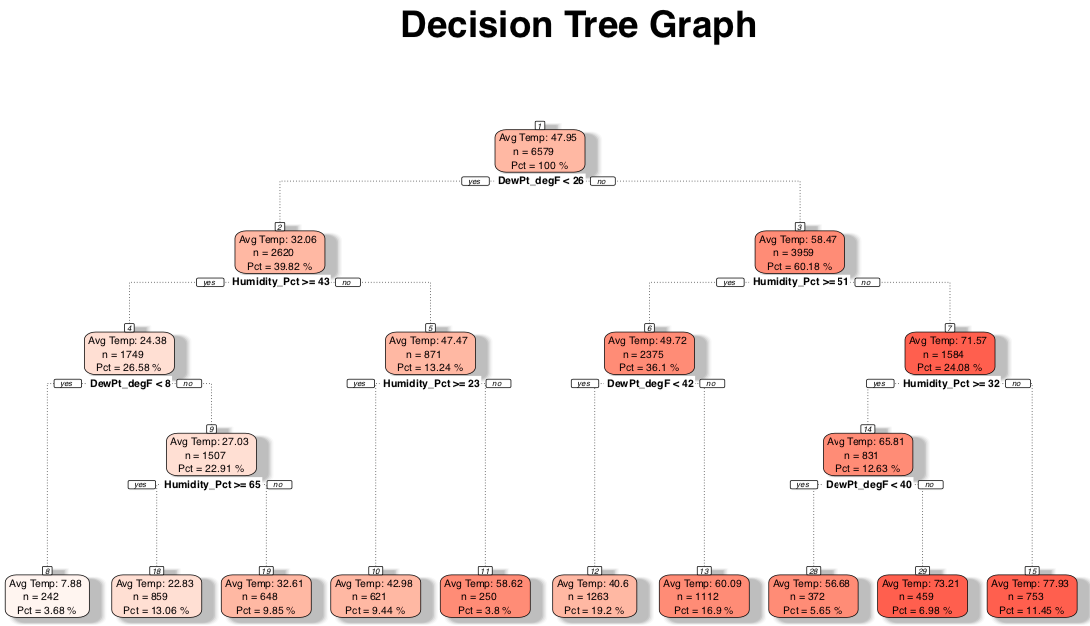

Below is the code I used to create a tree in python - this is helpful if our response was categorical.

In [128]:
# Extract single tree
estimator = fit.estimators_[5]


# Export as dot file
tree_graph = export_graphviz(estimator, out_file=None, 
                feature_names = list(X_train.columns.values),
                rounded = True, proportion = False, 
                precision = 4, filled = True)

# Display in jupyter notebook
# graphviz.Source(tree_graph)


#### Variable Importance Plot

Feature ranking:
1. feature 1 (0.615671)(DewPt_degF)
2. feature 0 (0.383246)(Humidity_Pct)
3. feature 6 (0.000264)(Pressure_Hg)
4. feature 7 (0.000183)(Solar_WatPerSqM)
5. feature 3 (0.000171)(WindDir_degNorth)
6. feature 5 (0.000158)(GustDir_degNorth)
7. feature 4 (0.000155)(Gust_mph)
8. feature 2 (0.000150)(Wind_mph)
9. feature 8 (0.000002)(Percip_in)


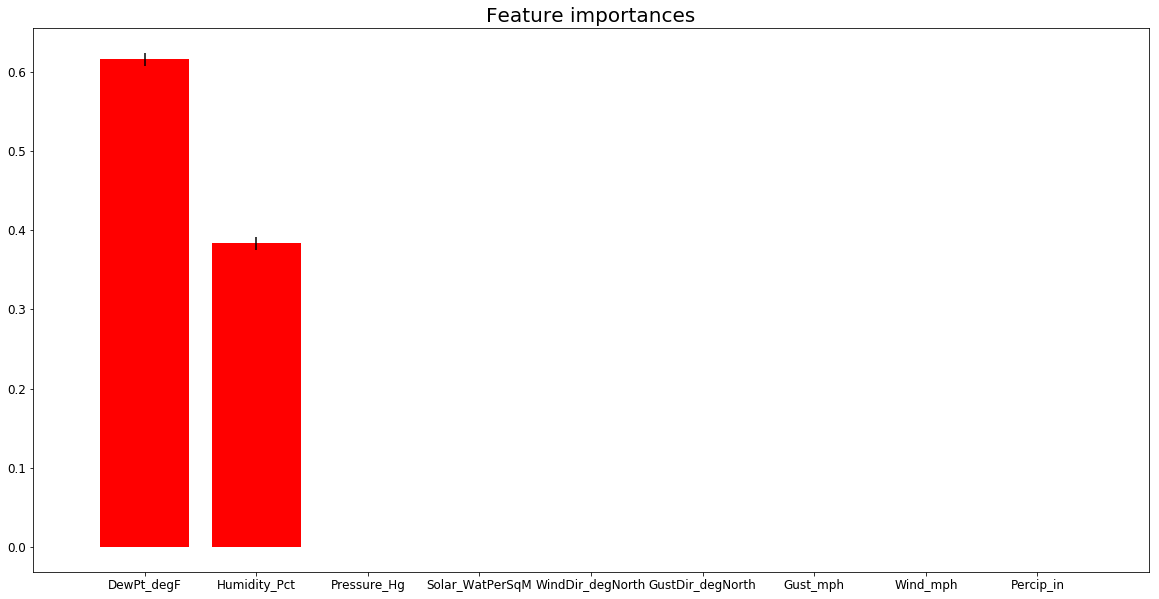

In [129]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = X_train.columns.values[indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + "(" + names[f] + ")")

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances", fontsize = 20)
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), names, fontsize = 12)
plt.xlim([-1, X_train.shape[1]])
plt.yticks(fontsize = 12)
plt.show()


Based on the variable importance plot we see that Dew Point (in $^oF$) is the most important variable in telling us about what the temperature will be. The second variable is Humidity Perctentage. The other variables provide essentially no important information about the predicted temperature. This follows with the decision tree that used Dew Point and Humidity Percentage to classify temperatures. 

#### Partial Dependence Plots

Partial plots show the relationship between each of the variables and the response.

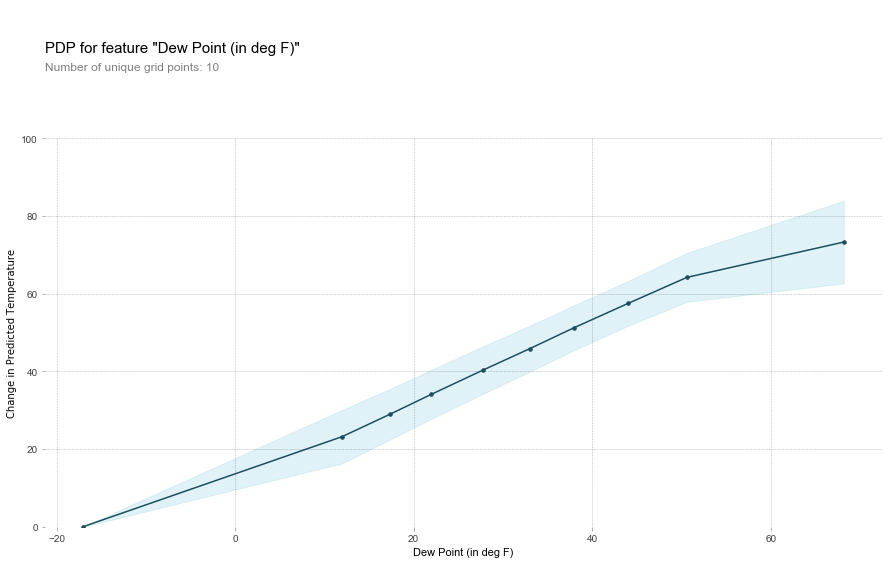

In [130]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=fit, dataset=X_train, 
                            model_features=list(X_train.columns.values), feature='DewPt_degF')

# plot it
pdp.pdp_plot(pdp_goals, 'Dew Point (in deg F)')
plt.ylim(0,100)
plt.ylabel('Change in Predicted Temperature')
plt.show()

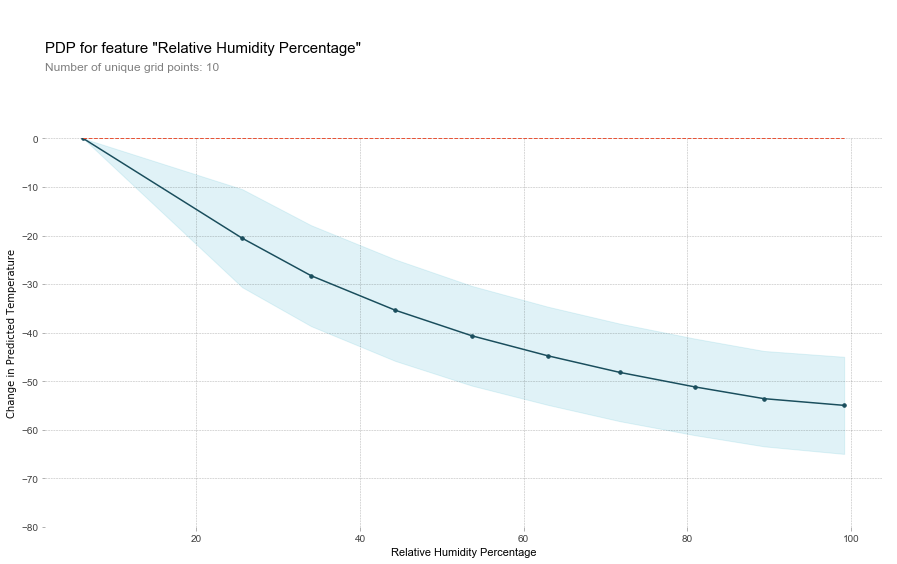

In [131]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=fit, dataset=X_train, 
                            model_features=list(X_train.columns.values), feature='Humidity_Pct')

# plot it
pdp.pdp_plot(pdp_goals, 'Relative Humidity Percentage')
plt.ylim(-80,0)
plt.ylabel('Change in Predicted Temperature')
plt.show()

For a partial dependence plot, we read the y axis as the change in the predicted temperature. The shaded line represents the confidence interval. In general, we see that a higher dew point will increase the temperature whereas a higher humidity percentage will decrease the temperature.

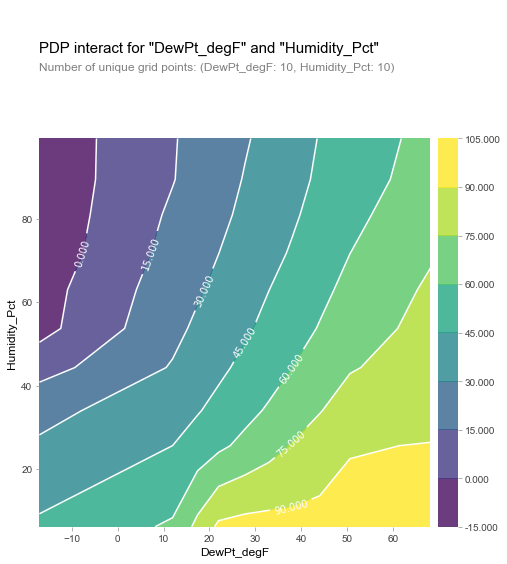

In [132]:
# 2D Partial Plot
features_to_plot = ['DewPt_degF', 'Humidity_Pct']
inter1  =  pdp.pdp_interact(model=fit, dataset=X_train, 
                            model_features=list(X_train.columns.values), 
                            features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

The Partial Dependence Plot shows the temperature prediction for the combination of Dew Point and Relative Humidity Percentage. 

### Evaluate Model

Now let's evaluate how effective our model is with mean squared error and $R^2$:

In [133]:
predictions = fit.predict(X_test)

mse = mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)
print("R-squared =" , round(R2,5) , "   MSE =" , round(mse,5))


R-squared = 0.99926    MSE = 0.30849


For this model, the mean squared error is **0.308** and $R^2$ is **0.999** making this model an almost perfect fit for the data!

If the predictions are perfect, the plot of predictions vs actual values will fit the line y=x.

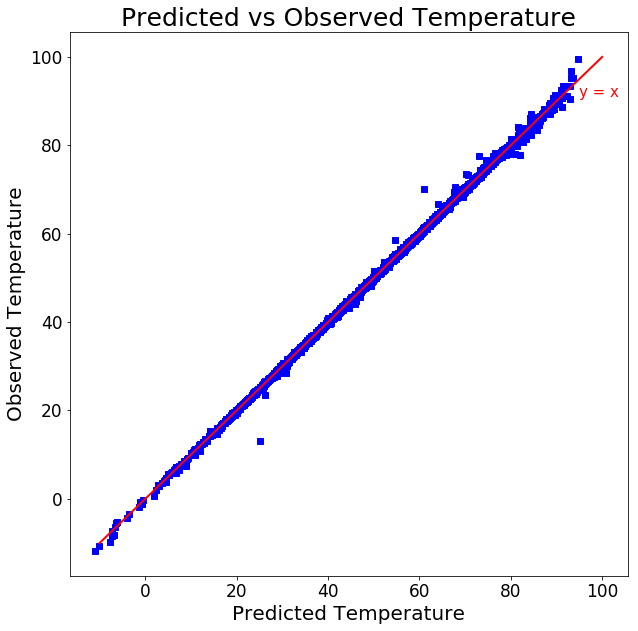

In [134]:
# plot predicted vs observed temperatures
plt.figure(figsize = (10,10))
plt.plot(predictions, y_test, 'bs')
plt.plot([-10, 100], [-10, 100], 'k-', lw = 2, color = 'Red')
plt.text(95, 91, 'y = x', color = 'Red', fontsize = 15)
plt.yticks(fontsize = 17)
plt.xticks(fontsize = 17)
plt.xlabel('Predicted Temperature', fontsize = 20)
plt.ylabel('Observed Temperature', fontsize = 20)
plt.title('Predicted vs Observed Temperature', fontsize = 25)
plt.show()


## Analysis - Future Predictions 

We've now seen that random forest is great for filling in missing data, but how about future predictions? In general, random forests don't provide a good fit when there's seasonality in time series data. Let's compare using the same process as before, except now our training data will be the first 75% of the data and our testing data will be the final 25%. 

In [135]:
np.random.seed(2019) # set seed for reproducible results

# make testing and training data sets
N = math.ceil(0.75*len(dat))
train = dat[1:N-1] # First 75% of the data
test = dat[N:len(dat)] # Final 25% of the data

X_train, y_train = train.drop('Temp_degF',axis=1), train['Temp_degF']
X_test, y_test = test.drop('Temp_degF',axis=1), test['Temp_degF']


In [136]:
np.random.seed(2019)
# Random Forest algorithm
rf = RandomForestRegressor(n_estimators = 500) #500 trees in the model

# Train the model on training data
fit = rf.fit(X_train, y_train)


### Evaluate Model

Let's evaluate how effective this model is compared to the previous model:

In [137]:
predictions = fit.predict(X_test)

mse = mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)
print("R-squared =" , round(R2,5) , "   MSE =" , round(mse,5))


R-squared = 0.93701    MSE = 7.93688


Our mean squared error has increased to **7.94** and our R-squared, while still good, is less than before - now **0.937**. In general, random forest is not as effective for making predictions

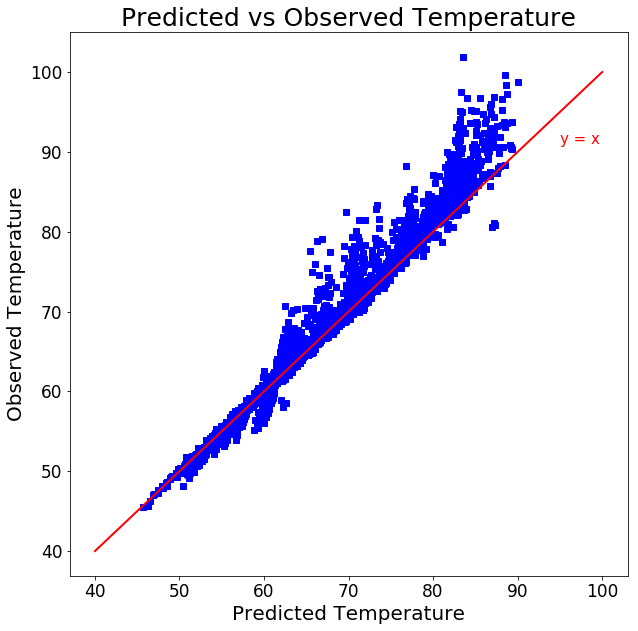

In [138]:
# plot predicted vs observed temperatures
plt.figure(figsize = (10,10))
plt.plot(predictions, y_test, 'bs')
plt.plot([40, 100], [40, 100], 'k-', lw = 2, color = 'Red')
plt.text(95, 91, 'y = x', color = 'Red', fontsize = 15)
plt.yticks(fontsize = 17)
plt.xticks(fontsize = 17)
plt.xlabel('Predicted Temperature', fontsize = 20)
plt.ylabel('Observed Temperature', fontsize = 20)
plt.title('Predicted vs Observed Temperature', fontsize = 25)
plt.show()


So the predicted value are pretty consistently higher than the observed value.

In general, the Random Forest algorithm will provide an average result and has trouble prediting future results (extrapolating) because it does not understand data with seasonality. 

## Analysis - Future Predictions with 5 years of data

Now we will take data over 5 years - from June 2014-June 2019 and see how well the algorithm performs over a longer time period.

In [139]:
# First we will read in the data and clean it
dat = pd.read_csv("dat_5yrs.csv")

# Remove first two columns
dat.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [140]:
np.random.seed(2019) # set seed for reproducible results

# make testing and training data sets
N = math.ceil(0.75*len(dat))
train = dat[1:N-1] # First 75% of the data
test = dat[N:len(dat)] # Final 25% of the data

X_train, y_train = train.drop('Temp_degF',axis=1), train['Temp_degF']
X_test, y_test = test.drop('Temp_degF',axis=1), test['Temp_degF']

In [141]:
np.random.seed(2019)
# Random Forest algorithm
rf = RandomForestRegressor(n_estimators = 500) #500 trees in the model

# Train the model on training data
fit = rf.fit(X_train, y_train)

### Evaluate Model 

Now we'll compare the previous model predicting future values to this model using 5 years of data.

In [142]:
predictions = fit.predict(X_test)

mse = mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)
print("R-squared =" , round(R2,5) , "   MSE =" , round(mse,5))

R-squared = 0.99986    MSE = 0.05611


Now our mean squared eror is **0.056** and the $R^2$ is **0.999**! This is essentially a perfect predicition! 

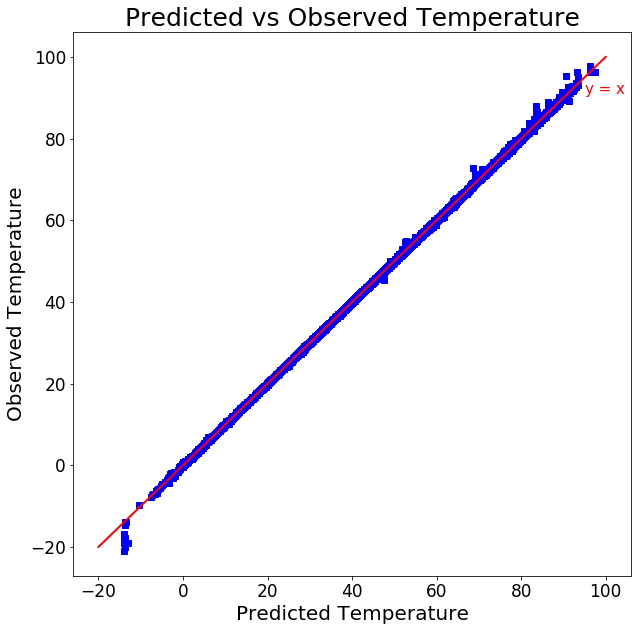

In [143]:
# plot predicted vs observed temperatures
plt.figure(figsize = (10,10))
plt.plot(predictions, y_test, 'bs')
plt.plot([-20, 100], [-20, 100], 'k-', lw = 2, color = 'Red')
plt.text(95, 91, 'y = x', color = 'Red', fontsize = 15)
plt.yticks(fontsize = 17)
plt.xticks(fontsize = 17)
plt.xlabel('Predicted Temperature', fontsize = 20)
plt.ylabel('Observed Temperature', fontsize = 20)
plt.title('Predicted vs Observed Temperature', fontsize = 25)
plt.show()